<a href="https://colab.research.google.com/github/Muhammadsulton1/genetic-algorithm-/blob/main/gen_bert_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import random
from sklearn import model_selection
from sklearn.model_selection import KFold 

from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score

import re
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

SEED = 17
np.random.seed(SEED)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
for com in train_df.query('target == 1')['text'].head(5):
    print(com)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [ ]:
for com in train_df.query('target == 0')['text'].head(5):
    print(com)

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [ ]:
df = train_df

In [ ]:
train_df['keyword'].fillna('Unknown', inplace=True)
train_df['location'].fillna('Unknown', inplace=True)

In [ ]:
train_df['keyword'] = train_df['keyword'].astype('category')
train_df['location'] = train_df['location'].astype('category')

In [ ]:
train_df['location'] = train_df['location'].apply(lambda x: x.replace('$$', ''))

In [ ]:
def preprocess_text(text, stem=False):
    text = text.lower()
    # удаление специальных символов
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    # удаление ссылок
    text = re.sub(r'http\S+', '', text)
    # удаление множественных пробелов
    text = re.sub('\s\s+', ' ', text)
    # удаление цифр
    text = re.sub(r'[0-9]+', '', text)
    # удаление стоп слов
    text = text.split(' ')
    text = ' '.join([word for word in text if not word in STOPWORDS])
    text = remove_stopwords(text)
    #приминение стемминга данных
    if stem:
        stem = SnowballStemmer(language='english')
        text = ' '.join([stem.stem(word) for word in text.split(' ')])
    #приминение лемматизации 
    else:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    text = text.strip()
    return text

In [ ]:
def tokenize_word(text, stem=True):
    #привидение к нижнему регистру
    text = text.lower()
    #удаление специальных символов
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    #удаление ссылок
    text = re.sub(r'http\S+', '', text)
    # удаление пробелов
    text = re.sub('\s\s+', ' ', text)
    # удаление цифр
    text = re.sub(r'[0-9]+', '', text)
    # удаление стоп слов
    text = text.split(' ')
    text = ' '.join([word for word in text if not word in STOPWORDS])
    text = remove_stopwords(text)
    if stem:
        stem = SnowballStemmer(language='english')
        text = ' '.join([stem.stem(word) for word in text.split(' ')])
    else:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    text = text.strip()
    return text.split(' ')

In [ ]:
#проверка корректности работы функции
preprocess_text(train_df['text'][0], stem=True)

'deed reason earthquak allah forgiv'

#приминение ранее созданных функций к текстовым данным

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_text(x))

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: tokenize_word(x))

In [ ]:
train_df

,id,keyword,location,text,target
0,1,Unknown,Unknown,"[deed, reason, earthquak, allah, forgiv]",1
1,4,Unknown,Unknown,"[forest, near, la, rong, sask, canada]",1
2,5,Unknown,Unknown,"[resid, ask, shelter, place, notifi, offic, ev...",1
3,6,Unknown,Unknown,"[peopl, receiv, wildfir, evacu, order, califor...",1
4,7,Unknown,Unknown,"[got, sent, photo, rubi, alaska, smoke, wildfi...",1
...,...,...,...,...,...
7608,10869,Unknown,Unknown,"[giant, crane, hold, bridg, collaps, nearbi, h...",1
7609,10870,Unknown,Unknown,"[ariaahrari, thetawniest, control, wild, calif...",1
7610,10871,Unknown,Unknown,"[m, utckm, s, volcano, hawaii]",1
7611,10872,Unknown,Unknown,"[polic, investig, ebik, collid, car, littl, po...",1


#после токенезации текста - текст хранится в формате списка, а мешок слов для кодирования принимает текстовые данные, поэтому меняет формат хранения данных на string 

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: str(x))

In [ ]:
train_df

,id,keyword,location,text,target
0,1,Unknown,Unknown,"['deed', 'reason', 'earthquak', 'allah', 'forg...",1
1,4,Unknown,Unknown,"['forest', 'near', 'la', 'rong', 'sask', 'cana...",1
2,5,Unknown,Unknown,"['resid', 'ask', 'shelter', 'place', 'notifi',...",1
3,6,Unknown,Unknown,"['peopl', 'receiv', 'wildfir', 'evacu', 'order...",1
4,7,Unknown,Unknown,"['got', 'sent', 'photo', 'rubi', 'alaska', 'sm...",1
...,...,...,...,...,...
7608,10869,Unknown,Unknown,"['giant', 'crane', 'hold', 'bridg', 'collaps',...",1
7609,10870,Unknown,Unknown,"['ariaahrari', 'thetawniest', 'control', 'wild...",1
7610,10871,Unknown,Unknown,"['m', 'utckm', 's', 'volcano', 'hawaii']",1
7611,10872,Unknown,Unknown,"['polic', 'investig', 'ebik', 'collid', 'car',...",1


In [ ]:
#удаляем ненужные колонки
train_df.drop(['id','keyword','location'],axis=1,inplace=True)

#Кодирование методом мешка слов

In [ ]:
#объявление мешка слов
cv_vectorizer = TfidfVectorizer()#CountVectorizer()
#подгонка мешка слов
cv_vectorizer.fit(train_df['text'])
print(len(cv_vectorizer.vocabulary_))
#кодирование данных
X = cv_vectorizer.transform(train_df['text'])
#из разряженной матрицы переводим в обычную матрицу
X = X.toarray()
#возвращаем список слов
feature_names = cv_vectorizer.get_feature_names()
#создаем датафрейм с колонками содержащие название слов
X=pd.DataFrame(X, columns = feature_names)
X = X[:7613]
Y = train_df['target'].values[:7613]
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=17)

13715


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#конвейрная обработка данных

In [ ]:
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), BernoulliNB(), 
          DecisionTreeClassifier(),SVC(), LinearSVC(),NuSVC(), XGBClassifier()]
score = []
for classifier in models:
  pipe = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', classifier)])
  pipe.fit(X_train, y_train) 
  score.append({'classifier_name':classifier, 
  'recall_score':recall_score(y_test,pipe.predict(X_test)),
  'precision_score':precision_score(y_test,pipe.predict(X_test)),
  'f1_score':f1_score(y_test,pipe.predict(X_test)),
  'accuracy_score':accuracy_score(y_test,pipe.predict(X_test))})

"\nmodels = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), BernoulliNB(), \n          DecisionTreeClassifier(),SVC(), LinearSVC(),NuSVC(), XGBClassifier()]\nscore = []\nfor classifier in models:\n  pipe = Pipeline(steps=[('scaler', StandardScaler()),\n                      ('classifier', classifier)])\n  pipe.fit(X_train, y_train) \n  score.append({'classifier_name':classifier, \n  'recall_score':recall_score(y_test,pipe.predict(X_test)),\n  'precision_score':precision_score(y_test,pipe.predict(X_test)),\n  'f1_score':f1_score(y_test,pipe.predict(X_test)),\n  'accuracy_score':accuracy_score(y_test,pipe.predict(X_test))})\n  "

In [ ]:
score_models = pd.DataFrame(score)

In [ ]:
score_models.sort_values(by=['accuracy_score'], ascending=False)

#на данном этапе выбираем модель с наилучшим качеством классификации, метрика качества зависит от того что для нас важнее

если модель сработала хорошо без подбора гипперпараметров, то имеет смысл его брать для передачи в генетический алгоритм.

насколько мне известно алгоритмы основанные на деревьях очень плохо работают на таком большом количестве признаков, лучше всего подходя линейные модели для классификации, а для мешка слов наиболее подходящими алгоритмами являются вероятностные

#лучшей моделью для классификции у нас является бернулиевский байес


In [ ]:
df = train_df.copy()

In [ ]:
train_df.head()

,text,target
0,"['deed', 'reason', 'earthquak', 'allah', 'forg...",1
1,"['forest', 'near', 'la', 'rong', 'sask', 'cana...",1
2,"['resid', 'ask', 'shelter', 'place', 'notifi',...",1
3,"['peopl', 'receiv', 'wildfir', 'evacu', 'order...",1
4,"['got', 'sent', 'photo', 'rubi', 'alaska', 'sm...",1


In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_text(x))
train_df['text'] = train_df['text'].apply(lambda x: x.split(' '))
train_df['text'] = train_df['text'].apply(lambda x: list(x))

In [ ]:
y = Y

#Создание генетического алгоритма

In [ ]:
class Gen:
    NUM_FOLDS = 3

    def __init__(self, X, y, randomSeed):

        self.randomSeed = randomSeed

        self.X = X
        self.y = y

        self.kfold = KFold(n_splits=self.NUM_FOLDS)

        self.classifier = BernoulliNB()

    def __len__(self):

        return self.X.shape[1]

    def getMeanAccuracy(self, zeroOneList):
        
        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)

        cv_results = model_selection.cross_val_score(self.classifier, currentX, self.y, cv=self.kfold, scoring='accuracy')

        return cv_results.mean()
    def getColumns(self,zeroOneList):
        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)
        return currentX



def main():
    gen = Gen(X, y, randomSeed=42)

    allOnes = [1] * len(gen)
    print("-- All features selected: ", allOnes, ", accuracy = ", gen.getMeanAccuracy(allOnes))


if __name__ == "__main__":
    main()

-- All features selected:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 4.3 MB/s 


gen	nevals	max     	avg    
0  	70    	0.720536	0.69751
1  	62    	0.720926	0.701602
2  	62    	0.725194	0.706638
3  	69    	0.726813	0.711589
4  	56    	0.728774	0.715701
5  	63    	0.732015	0.717788
6  	59    	0.732015	0.719788
7  	63    	0.733461	0.72236 
8  	63    	0.73267 	0.724063
9  	58    	0.73319 	0.725374
10 	69    	0.735289	0.726369
11 	66    	0.737411	0.727221
12 	62    	0.737358	0.728779
13 	66    	0.740002	0.73084 
14 	62    	0.742413	0.732716
15 	70    	0.742691	0.734489
16 	62    	0.744126	0.736655
17 	63    	0.745714	0.737942
18 	62    	0.745714	0.738831
19 	66    	0.745451	0.740012
20 	64    	0.746972	0.740732
21 	64    	0.747321	0.742362
22 	66    	0.748266	0.74376 
23 	66    	0.748793	0.745005
24 	64    	0.749159	0.745928
25 	62    	0.749821	0.746806
26 	68    	0.750477	0.747555
27 	66    	0.75177 	0.748197
28 	66    	0.751259	0.748804
29 	64    	0.751375	0.749352
30 	62    	0.751178	0.74973 
31 	59    	0.75118 	0.750049
32 	54    	0.75194 	0.750251
33 	64    	0.752

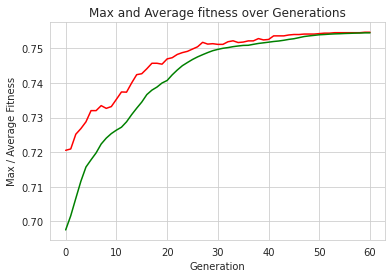

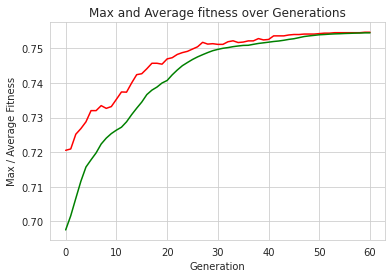

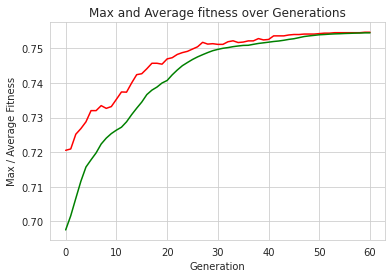

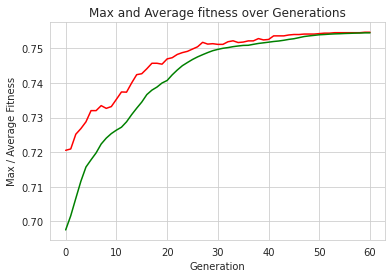

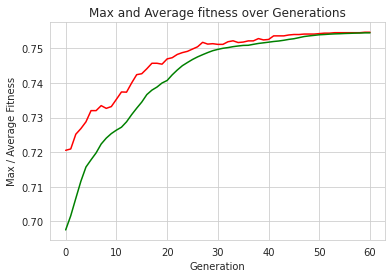

In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import base, algorithms
import numpy

#параметры генетического алгоритма:
POPULATION_SIZE = 70 
P_CROSSOVER = 0.9 
P_MUTATION = 0.1
MAX_GENERATIONS = 60
HALL_OF_FAME_SIZE = 5

FEATURE_PENALTY_FACTOR =  0.000001 #0.001

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

gen = Gen(X, y, RANDOM_SEED)

toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("zeroOrOne", random.randint, 0, 1)

toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(gen))

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


def genClassificationAccuracy(individual):
    numFeaturesUsed = sum(individual)
    if numFeaturesUsed == 0:
        return 0.0,
    else:
        accuracy = gen.getMeanAccuracy(individual)
        return accuracy - FEATURE_PENALTY_FACTOR * numFeaturesUsed,  # возвращает кортеж


toolbox.register("evaluate", genClassificationAccuracy)

toolbox.register("select", tools.selTournament, tournsize=2)

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(gen))


#def main():
gen_score = []
population = toolbox.populationCreator(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", numpy.max)
stats.register("avg", numpy.mean)

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

print("- Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
  #записываем точность в список
  gen_score.append(gen.getMeanAccuracy(hof.items[i]))
  print(i, ": ", hof.items[i], ", fitness = ", hof.items[i].fitness.values[0],
              ", accuracy = ", gen.getMeanAccuracy(hof.items[i]), ", features = ", sum(hof.items[i]))
for j in range(HALL_OF_FAME_SIZE):
  #создаем новый датафрейм откуда будем брать признаки
  new_frame = pd.DataFrame(gen.getColumns(hof.items[j]))


  maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

  sns.set_style("whitegrid")
  plt.plot(maxFitnessValues, color='red')
  plt.plot(meanFitnessValues, color='green')
  plt.xlabel('Generation')
  plt.ylabel('Max / Average Fitness')
  plt.title('Max and Average fitness over Generations')
  plt.show()


#if __name__ == "__main__":
    #main()

In [ ]:
gen_score

[0.7614610825710662,
 0.7614610825710662,
 0.7614610825710662,
 0.7614610825710662,
 0.7613297455602965]

In [ ]:
cols = list(new_frame.columns)

In [ ]:
def intersection_list(list1, list2): 
   list3 = [value for value in list1 if value in list2] 
   return list3 
 
print(intersection_list(train_df['text'].iloc[0], cols))

['deed', 'earthquak', 'allah', 'forgiv']


In [ ]:
df['new'] = train_df['text'].apply(lambda x: intersection_list(cols,x))

In [ ]:
df.head()

,text,target,new
0,"['deed', 'reason', 'earthquak', 'allah', 'forg...",1,"[allah, deed, earthquak, forgiv]"
1,"['forest', 'near', 'la', 'rong', 'sask', 'cana...",1,"[la, near, sask]"
2,"['resid', 'ask', 'shelter', 'place', 'notifi',...",1,"[evacu, expect, resid]"
3,"['peopl', 'receiv', 'wildfir', 'evacu', 'order...",1,"[california, evacu, peopl, wildfir]"
4,"['got', 'sent', 'photo', 'rubi', 'alaska', 'sm...",1,"[got, photo, rubi, school, sent, smoke, wildfir]"


In [ ]:
df['new'] = df['new'].apply(lambda x: str(x))
df['new'] = df['new'].apply(lambda x: preprocess_text(x))

In [ ]:
df.head()

,text,target,new
0,"['deed', 'reason', 'earthquak', 'allah', 'forg...",1,allah deed earthquak forgiv
1,"['forest', 'near', 'la', 'rong', 'sask', 'cana...",1,la near sask
2,"['resid', 'ask', 'shelter', 'place', 'notifi',...",1,evacu expect resid
3,"['peopl', 'receiv', 'wildfir', 'evacu', 'order...",1,california evacu peopl wildfir
4,"['got', 'sent', 'photo', 'rubi', 'alaska', 'sm...",1,got photo rubi school sent smoke wildfir


In [ ]:
df.drop(['text'],axis=1,inplace=True)

In [ ]:
df.shape

(7613, 2)

In [ ]:
df.rename(columns={'new':'text'},inplace=True)

In [ ]:
df.head()

,target,text
0,1,allah deed earthquak forgiv
1,1,la near sask
2,1,evacu expect resid
3,1,california evacu peopl wildfir
4,1,got photo rubi school sent smoke wildfir


In [ ]:
df.to_csv('gen_bert.csv')

In [ ]:
from google.colab import files
files.download('gen_bert.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#берт применялся для сравнения улучшится ли точность классификации берта после отбора наиболее информативных признаков с помощью генетического алгоритма

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from torch.optim import Adam
from tqdm import tqdm
import torch
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
import nltk
nltk.download('punkt')

#Bert для классификации на отобранных признаках

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = [0,1]

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['target']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            #заполняем список для проверки гипотезы
            score = []
            score.append(total_acc_val / len(val_data))
                  
EPOCHS = 3
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)
4
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)